# Amazon Product Quality Drivers & Customers Sentiment Analysis

---

## Project Overview & Business Value

This project utilizes Amazon product data, including pricing and customer reviews, to uncover the key factors that **drive high customer ratings (4.0 and 5.0)**. By leveraging **Natural Language Processing (NLP)** and **Classification Modeling**,
the analysis identifies specific product features and customer sentiments that lead to satisfaction.

**The primary business objective is to provide actionable recommendations for:**
1. **Product Development:** Knowing where to focus quality improvements.
2. **Marketing Strategy:** Understanding which product attributes to highlight
3. **Pricing/Promotion:** Evaluating the impact of discounts on perceived value.

---

## Key Business Questions Answered

1. Which product categories show the strongest correlation between **price discounts** and high ratings?
2. What are the top 5 most influential product attributes (from the product description) that predict a 5-star rathing?
3. Does the sentiment score derived from the *review content* significantly outperform the numerical rating in predicting overall satisfaction?
4. What are the common topics or themes in low-rated reviews that demand immediate business attention?

---

## Dataset Column Description (Data Dictionary)

| Column Name | Data Type (Implied) | Description & Use in Project | 
| :--- | :--- | :--- |
| `product_id` | String | Unique identifier for the product. |
| `product_name` | String | Full name of the product. |
| `category` | String | Primary category of the product (e.g., Electronics, Fashion). **Used for segmentation.** |
| `discounted_price` | String/Numeric | The price the customer paid. **Used in pricing analysis.** |
| `actual_price` | String/Numeric | The original list price. |
| `discount_percentage` | String/Numeric | The calculated discount given. **Used as a key driver feature.** |
| `rating` | Float | The numerical rating (1.0 to 5.0). **Used to create the binary target variable.** |
| `rating_count` | Integer | The total number of votes for the rating. **Used as a proxy for product popularity/sales volume.** |
| `about_product` | String | Detailed product features/description. **Source for keyword-based feature engineering (e.g., "durable").** |
| `user_id` | String | Unique identifier for the reviewer. |
| `user_name` | String | Name of the reviewer. |
| `review_id` | String | Unique identifier for the specific review. |
| `review_title` | String | Short subject line of the review. **Used in NLP/sentiment analysis.** |
| `review_content` | String | Full text of the review. **Primary source for sentiment scoring and topic modeling (NLP).** |
| `img_link` | String | Link to the product image. |
| `product_link` | String | Link to the product's Amazon page. |

---

## Technical Stack & Methodology

| Component | Techniques / Libraries Used |
| :--- | :--- |
| **Data Cleaning** | Python (Pandas, NumPy) |
| **Feature Engineering** | Keyword Extraction, Text Length Calculation |
| **Sentiment Analysis** | **Natural Language Toolkit (NLTK)** - VADER Sentiment Lexicon |
| **Modeling** | **Scikit-learn (sklearn)** - Random Forest Classifier, Logistic Regression |
| **Evaluation** | Confusion Matrix, Feature Importance, Classification Report (Precision/Recall) |
| **Visualization** | Matplotlib, Seaborn |

In [2]:
# Data Manipulation Imports
import pandas as pd
import numpy as np

# Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and Text Processing Imports
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Evaluation Imports
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [3]:
# NOTE: This cell only needs to be run once per machine
# to download the necessary lexicon for VADER sentiment analysis.
# You can comment it out after the first successful run.

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rharv\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
# Load in dataset
amazon_sales_raw = pd.read_csv('amazon_sales_dataset.csv')

In [11]:
# Displays head of the data for inspection
amazon_sales_raw.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [11]:
amazon_sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

In [6]:
# Checks to see how many null values are in the dataset
amazon_sales_raw.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [10]:
# Sets all text columns to variable to check for empty entries
check_cols = ['review_title', 'review_content', 'about_product']

print('Data Quality Check: Inspecting Text Columns for Empty Strings')

# Iterate through stored columns to check
for col in check_cols:
    # Convert to string for safe handling, use .str.strip() to remove whitespace, check if empty
    empty_count =  amazon_sales_raw[col].astype(str).str.strip().eq('').sum()

    # Runs if there any empty entries in current column
    if empty_count > 0:
        print(f"'{col}': {empty_count} rows contain only whitespace or are empty strings.")

        # Replace these effectively null values with an actual empty string to prevent errors in later NLP steps
        amazon_sales_raw[col] = amazon_sales_raw[col].replace(r'^\s*$', '', regex=True)
        print(f"   -> {empty_count} rows replaced with an empty string ('') for NLP processing.")

    else:
        print(f"'{col}': Clean (0 empty/whitespace rows detected).")


Data Quality Check: Inspecting Text Columns for Empty Strings
'review_title': Clean (0 empty/whitespace rows detected).
'review_content': Clean (0 empty/whitespace rows detected).
'about_product': Clean (0 empty/whitespace rows detected).


## Data Cleaning & Standardization Summary

This section details all transformations required to prepare the raw data for numerical analysis and NLP modeling, based on the initial inspection where all key columns were found to be of the 'object' (string) data type.

| Issue (Column) | Why the Change is Needed or Preferred | How the Change is Implemented |
| :--- | :--- | :--- |
| **Missing Data** (`rating_count`) | Two rows are missing a value in this critical popularity metric. Dropping them is statistically negligible given the dataset size (>1K rows). | **Drop** the 2 rows where `rating_count` is null (`NaN`). |
| **Target Variable** (`rating`) | The model requires a binary target variable to classify success/failure. | **Create** a new boolean column, `High_Rating`, where **True** if `rating` $\ge 4.0$ (High Satisfaction) and **False** otherwise. |
| **Currency** (`discounted_price`, `actual_price`) | Columns are strings with the `₹` symbol and commas. Prices need to be numeric and standardized to USD for portfolio clarity. | 1. **Remove** `₹` and `,`. 2. **Convert** to `float` (INR). 3. **Divide** by a fixed exchange rate (e.g., $82.0$) to convert to **USD**. |
| **Percentage** (`discount_percentage`) | Column is a string with the `%` symbol. It must be a decimal for statistical modeling. | 1. **Remove** the `%` symbol. 2. **Convert** to `float`. 3. **Divide** by 100 to yield a decimal (e.g., $0.64$). |
| **Popularity Metric** (`rating_count`) | Column is a string containing commas (e.g., `24,269`). It needs to be a numerical integer type. | 1. **Remove** the comma (`,`). 2. **Convert** the resulting string to an `int`. |
| **Text Data** (All Text Columns) | All text columns were checked and found to be free of purely empty or whitespace-only strings. | **No action required** on missing text values. All text is retained and ready for direct use in NLP (Sentiment Analysis, Feature Engineering). |
| **Cleanup** (Raw Columns) | Retaining the original string columns (`discounted_price`, `rating_count`, etc.) is redundant after cleaning. | **Drop** the original raw columns once the new, clean numerical columns are created. |

In [12]:
amazon_sales_cleaned = amazon_sales_raw.copy()

In [25]:
# Handle Missing Data by Dropping Nulls
amazon_sales_cleaned = amazon_sales_cleaned.dropna(subset=['rating_count'])

In [ ]:
# Clean Price and convert to USD
USD_TO_INR_RATE = 82.0 # Assumed fixed exchange rate for documentation

for col in ['discounted_price', 'actual_price']:
    # Clean symbol and convert to INR (numerical)
    amazon_sales_cleaned[f'{col}_inr'] = (
        amazon_sales_cleaned[col]
        .astype(str)
        .str.replace('₹', '', regex=False)
        .str.replace(',', '', regex=False)
        .astype(float)
    )
    # Convert INR to USD and round to 2 decimal places
    amazon_sales_cleaned[f'{col}_usd'] = (amazon_sales_cleaned[f'{col}_inr'] / USD_TO_INR_RATE).round(2)

In [ ]:
# Clean and convert Discount Percentage
amazon_sales_cleaned['discount_percentage_dec'] = (
    amazon_sales_cleaned['discount_percentage']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float)
    / 100
)

In [27]:
# Clean and Convert Rating Count
amazon_sales_cleaned['rating_count_clean'] = (
    amazon_sales_cleaned['rating_count']
    .astype(str)
    .str.replace(',', '', regex=False)
    .astype(int)
)

In [ ]:
#  CODE ATTEMPT THAT FAILED: Initial attempt to convert rating to float
amazon_sales_cleaned['rating'] = amazon_sales_cleaned['rating'].astype(float)

ValueError: could not convert string to float: '|'

## Data Quality Issue: Non-Numeric Entry in 'rating' Column

The direct conversion of the `rating` column to `float` failed due to a `ValueError`. Inspection revealed that a single row contained the non-numeric character **`|`** instead of a rating.

This type of error handling is crucial for data robustness. Since the entry was unusable for modeling and statistically negligible (1 row), the solution is to treat it as a missing value and drop the row.

**Action:** Replace the `'|'` with `np.nan`, drop the resulting null row, and then successfully convert the column to `float`.

In [ ]:
error_rows = amazon_sales_cleaned[
    amazon_sales_cleaned['rating'].astype(str).str.contains(r'\|', regex=True)
]

# Display the relevant columns for inspection
print(f"--- {len(error_rows)} Rows Containing '|' in the 'rating' Column ---")
if not error_rows.empty:
    # Display product ID, rating, rating count, and the first part of the review content
    print(error_rows[['product_id', 'rating', 'rating_count', 'review_content']].head(10))
else:
    print("No rows containing the '|' character were found.")

--- 1 Rows Containing '|' in the 'rating' Column ---
      product_id rating rating_count  \
1279  B08L12N5H1      |          992   

                                         review_content  
1279  Does the job well,doesn't work on sand. though...  


In [21]:
# Replace the single instance of '|' with a true NaN value
amazon_sales_cleaned['rating'] = amazon_sales_cleaned['rating'].replace('|', np.nan)

# Drop the row containing the NaN value in the 'rating' column
amazon_sales_cleaned = amazon_sales_cleaned.dropna(subset=['rating'])

> Now that the '|' has been addressed and removed, I will now change the column to type float

In [ ]:
# Converts rating to float
amazon_sales_cleaned['rating'] = amazon_sales_cleaned['rating'].astype(float)

In [32]:
# Create the Final Binary Target Bucket
amazon_sales_cleaned['High_Rating'] = (amazon_sales_cleaned['rating'] >= 4.0).astype(int)

In [35]:
columns_to_drop = [
    'product_id', 
    'user_id', 
    'user_name', 
    'review_id', 
    'img_link', 
    'product_link',
    'rating',
    'discounted_price',      
    'actual_price',          
    'discount_percentage',   
    'rating_count',
    'discounted_price_inr',  
    'actual_price_inr'
]

amazon_sales_cleaned = amazon_sales_cleaned.drop(columns=columns_to_drop)

In [36]:
amazon_sales_cleaned.head()

,product_name,category,about_product,review_title,review_content,discounted_price_usd,actual_price_usd,discount_percentage_dec,rating_count_clean,High_Rating
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...,"Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,4.87,13.40,0.64,24269,1
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,2.43,4.26,0.43,43994,1
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...,"Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",2.43,23.16,0.90,7928,0
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...,"Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",4.01,8.52,0.53,94363,1
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",1.88,4.87,0.61,16905,1


In [37]:
amazon_sales_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1462 entries, 0 to 1464
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_name             1462 non-null   object 
 1   category                 1462 non-null   object 
 2   about_product            1462 non-null   object 
 3   review_title             1462 non-null   object 
 4   review_content           1462 non-null   object 
 5   discounted_price_usd     1462 non-null   float64
 6   actual_price_usd         1462 non-null   float64
 7   discount_percentage_dec  1462 non-null   float64
 8   rating_count_clean       1462 non-null   int32  
 9   High_Rating              1462 non-null   int32  
dtypes: float64(3), int32(2), object(5)
memory usage: 114.2+ KB


# Exploratory Data Analysis (EDA) Plan

The EDA phase is critical for understanding the distribution of our key variables, validating the business hypotheses, and identifying final features for the classification model.

---

## Primary EDA Objectives

1.  **Validate the Target:** Confirm the distribution of the `High_Rating` variable (our 1/0 target) to check for class imbalance.
2.  **Test Pricing Hypotheses:** Investigate the relationship between pricing strategy and customer satisfaction.
3.  **Identify Feature Importance:** Uncover correlations between numerical drivers (`discount_percentage_dec`, `rating_count_clean`) and the target variable.
4.  **Prepare Text for NLP:** Summarize characteristics of the text data (`review_content`, `about_product`).

---

## Key Analysis and Visualizations

| Analysis Goal | Key Variables | Visualization / Metric | Business Insight to Extract |
| :--- | :--- | :--- | :--- |
| **Target Distribution** | `High_Rating` | Count Plot / Percentage of 1s (High Ratings) | Determine if the dataset is **balanced** or if **oversampling/undersampling** is needed later. |
| **Category Segmentation** | `category`, `High_Rating` | Bar Chart (High Rating % per Category) | Identify which **product categories** are inherently more or less satisfying to customers. |
| **Discount Elasticity** | `discount_percentage_dec`, `High_Rating` | Violin/Box Plot of Discount % vs. Target | Does a deeper discount increase the likelihood of a high rating? (Testing the perceived value hypothesis) |
| **Popularity vs. Rating** | `rating_count_clean`, `High_Rating` | Scatter Plot (Log-transformed Rating Count vs. Rating) | Are high ratings merely driven by popular products, or are genuinely high-quality items rated well regardless of volume? |
| **Price Distribution** | `discounted_price_usd` | Histogram/Density Plot | Understand the **typical price range** of products in the dataset. |
| **Review Length** | `review_content` length, `High_Rating` | Box Plot/T-Test | Do people write **longer reviews** when they are highly satisfied (1) versus unsatisfied (0)? (Proxy for strong sentiment). |

---

## Feature Engineering Preparation (NLP Focus)

This section will analyze the raw text data to set the stage for our NLP feature creation:

1.  **Word Clouds:** Visualize the most frequent words in `review_content` for both the **High Rating (1)** and **Low Rating (0)** groups to identify immediate qualitative differences.
2.  **Category Terminology:** Inspect the `about_product` column, particularly by category, to guide the **keyword extraction** process for modeling (e.g., identifying terms like "battery life," "durable," "fast").

--- High_Rating (1/0) Counts ---
High_Rating
1    1109
0     353
Name: count, dtype: int64

--- High_Rating (1/0) Percentages ---
High_Rating
1    75.85
0    24.15
Name: proportion, dtype: float64


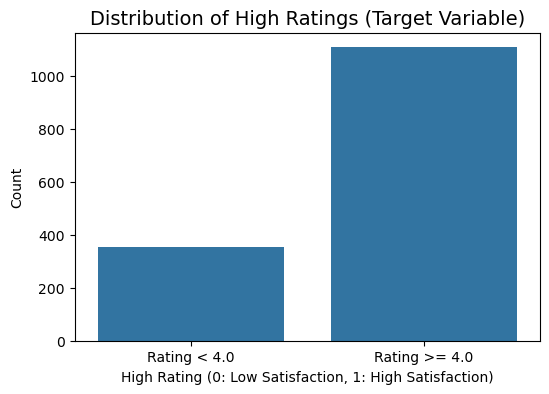

In [41]:
# Calculate the counts and percentages
target_counts = amazon_sales_cleaned['High_Rating'].value_counts()
target_percentages = amazon_sales_cleaned['High_Rating'].value_counts(normalize=True) * 100

print("--- High_Rating (1/0) Counts ---")
print(target_counts)
print("\n--- High_Rating (1/0) Percentages ---")
print(target_percentages.round(2))

plt.figure(figsize=(6, 4))
sns.countplot(x='High_Rating', data=amazon_sales_cleaned)
plt.title('Distribution of High Ratings (Target Variable)', fontsize=14)
plt.xlabel('High Rating (0: Low Satisfaction, 1: High Satisfaction)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Rating < 4.0', 'Rating >= 4.0'])
plt.show()

## EDA Finding 1: Target Variable Imbalance

The initial analysis of the target variable, `High_Rating` (1 for $\ge 4.0$ and 0 for $< 4.0$), reveals a **significant class imbalance**.

| Rating Group | Count | Percentage |
| :--- | :--- | :--- |
| **High Rating (1)** | 1,109 | **75.85%** |
| **Low Rating (0)** | 353 | **24.15%** |

---

### Implications and Modeling Strategy

This $76\%/24\%$ split requires careful consideration during the modeling phase, as simply maximizing overall accuracy will be misleading. The model could achieve $76\%$ accuracy by predicting '1' (High Rating) for every product.

| Implication | Actionable Strategy |
| :--- | :--- |
| **Misleading Accuracy** | Prioritize **Precision, Recall, and F1-Score** (especially for the minority class, 0) over overall accuracy when evaluating models. |
| **Poor Minority Prediction** | During model training (e.g., using `RandomForestClassifier`), we will apply **class weighting** (e.g., setting `class_weight='balanced'`). This tells the model to pay more attention to the less frequent Low Rating (0) examples. |
| **Focus on Insights** | The primary goal remains identifying the **drivers** (feature importance) that differentiate the two groups, rather than achieving perfect predictive performance. |


--- Mean High_Rating Percentage by Category ---
category
Electronics|Mobiles&Accessories|MobileAccessories|Décor                                                  100.0
Electronics|Headphones,Earbuds&Accessories|Cases                                                         100.0
Electronics|Mobiles&Accessories|MobileAccessories|Photo&VideoAccessories|SelfieSticks                    100.0
Electronics|PowerAccessories|SurgeProtectors                                                             100.0
Health&PersonalCare|HomeMedicalSupplies&Equipment|HealthMonitors|WeighingScales|DigitalBathroomScales    100.0
                                                                                                         ...  
Home&Kitchen|Heating,Cooling&AirQuality|RoomHeaters|HalogenHeaters                                         0.0
Home&Kitchen|Heating,Cooling&AirQuality|RoomHeaters|HeatConvectors                                         0.0
Home&Kitchen|Kitchen&HomeAppliances|Coffee,Tea&Espress

C:\Users\rharv\AppData\Local\Temp\ipykernel_17076\3173882181.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


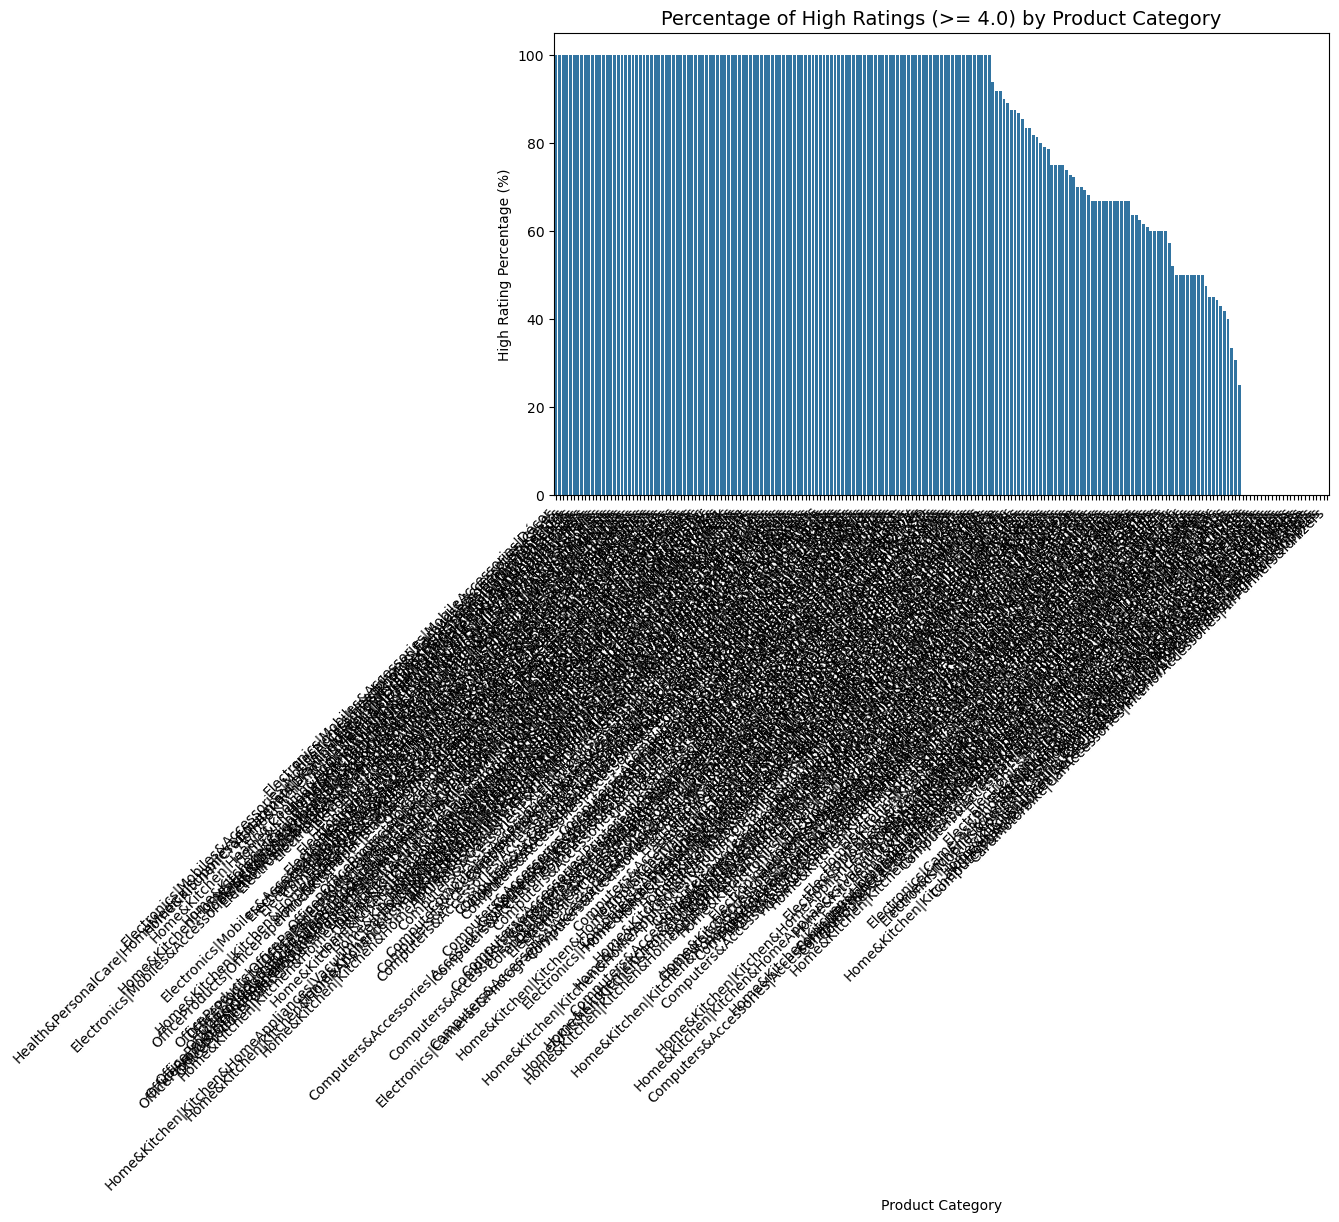

In [42]:
# Group by category and calculate the mean of 'High_Rating' (which gives the percentage of 1s)
category_ratings = amazon_sales_cleaned.groupby('category')['High_Rating'].mean().sort_values(ascending=False) * 100

print("\n--- Mean High_Rating Percentage by Category ---")
print(category_ratings.round(2))

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=category_ratings.index, y=category_ratings.values)
plt.title('Percentage of High Ratings (>= 4.0) by Product Category', fontsize=14)
plt.ylabel('High Rating Percentage (%)')
plt.xlabel('Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## EDA Finding 2: Category Granularity Issue

### The Problem

During the analysis of **High Rating Percentage by Category**, the resulting bar chart was illegible and messy due to an excessive number of unique labels ($\text{Length} = 211$). The raw `category` column contains long, hierarchical strings (e.g., `Electronics|Mobiles&Accessories|...`).

### The Diagnosis

The existing category feature is **too granular** for effective visualization and modeling segmentation. We need to simplify the category structure to extract the primary, top-level product grouping.

### The Fix: Feature Engineering the Category

To resolve this, a new categorical feature will be engineered:

1.  **New Feature:** `top_category`
2.  **Method:** Use string manipulation to split the raw `category` string at the first pipe delimiter (`|`) and retain only the first element.

This will reduce the feature space to a manageable number of primary categories, allowing for a clean, interpretable visualization and a useful feature for the classification model. The segmentation analysis will then be successfully rerun using this new feature.

In [43]:
# Extract the first category before the first pipe '|'
amazon_sales_cleaned['top_category'] = (
    amazon_sales_cleaned['category']
    .astype(str)
    .str.split('|', expand=True)[0]
)

# Check the new, simplified categories
print("--- Top 10 Simplified Categories ---")
print(amazon_sales_cleaned['top_category'].value_counts().head(10))

--- Top 10 Simplified Categories ---
top_category
Electronics              526
Computers&Accessories    451
Home&Kitchen             447
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: count, dtype: int64



--- Mean High_Rating Percentage by Top-Level Category ---
top_category
Health&PersonalCare      100.00
HomeImprovement          100.00
OfficeProducts           100.00
Toys&Games               100.00
Computers&Accessories     83.59
Electronics               74.71
Home&Kitchen              67.79
MusicalInstruments        50.00
Car&Motorbike              0.00
Name: High_Rating, dtype: float64


C:\Users\rharv\AppData\Local\Temp\ipykernel_17076\1059634778.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_category_ratings.index, y=top_category_ratings.values, palette='viridis')


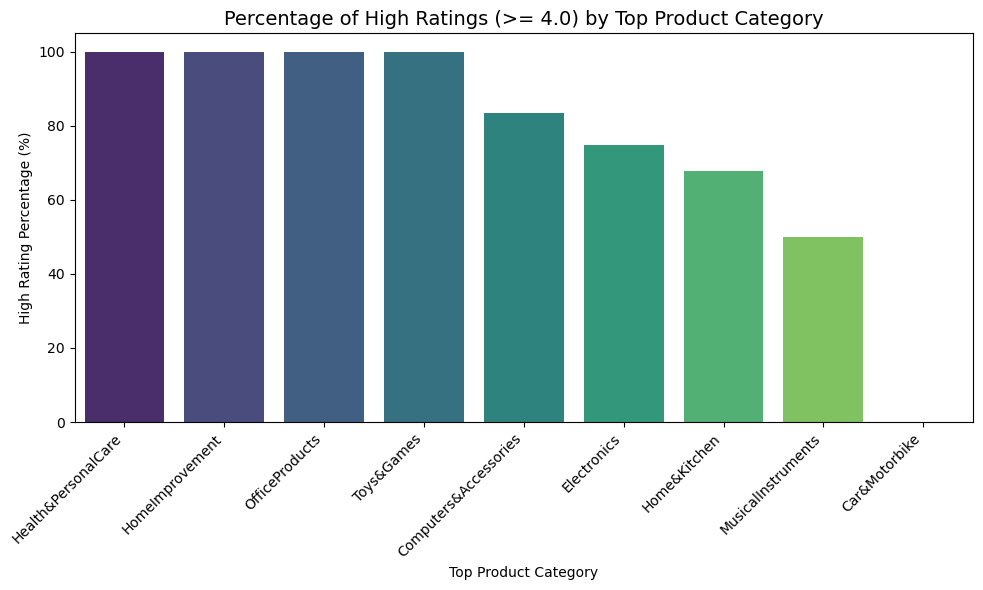

In [44]:
# Group by the new top category and calculate the mean of 'High_Rating'
top_category_ratings = (
    amazon_sales_cleaned.groupby('top_category')['High_Rating']
    .mean()
    .sort_values(ascending=False) * 100
)

print("\n--- Mean High_Rating Percentage by Top-Level Category ---")
print(top_category_ratings.round(2))

# Visualize the distribution with the cleaned categories
plt.figure(figsize=(10, 6))
sns.barplot(x=top_category_ratings.index, y=top_category_ratings.values, palette='viridis')
plt.title('Percentage of High Ratings (>= 4.0) by Top Product Category', fontsize=14)
plt.ylabel('High Rating Percentage (%)')
plt.xlabel('Top Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## EDA Finding 3: Customer Satisfaction Varies by Top Category

The analysis of the `top_category` feature reveals that customer satisfaction (i.e., the rate of $\text{Rating} \ge 4.0$) is highly unequal across different product groupings.

### Key Insights from Segmentation

| Top Category | High Rating % ($\ge 4.0$) | Business Implication |
| :--- | :--- | :--- |
| **Health&PersonalCare** | $100.00\%$ | **Strong Quality:** Products in these categories are highly satisfying. Focus can shift from quality control to scaling production/marketing. |
| **Car&Motorbike** | $0.00\%$ | **Critical Quality Issue:** Every single product in this category failed to meet the High Rating threshold. This requires immediate quality control investigation and product redesign. |
| **Computers&Accessories** | $83.59\%$ | **Generally Strong:** A solid performance, indicating most products are meeting expectations. |
| **MusicalInstruments** | $50.00\%$ | **Neutral/Unpredictable:** Satisfaction is a toss-up. This is an ideal category to test if our **numerical drivers** (like discount magnitude) are the key factors differentiating the satisfied from the unsatisfied customer. |

### Conclusion

The strong divergence in satisfaction across categories confirms that the **drivers of high ratings will not be universal**. We must examine numerical features like pricing and popularity to see if they can explain the variance in the $50\% - 85\%$ satisfaction categories (like Musical Instruments and Electronics).

C:\Users\rharv\AppData\Local\Temp\ipykernel_17076\665834961.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


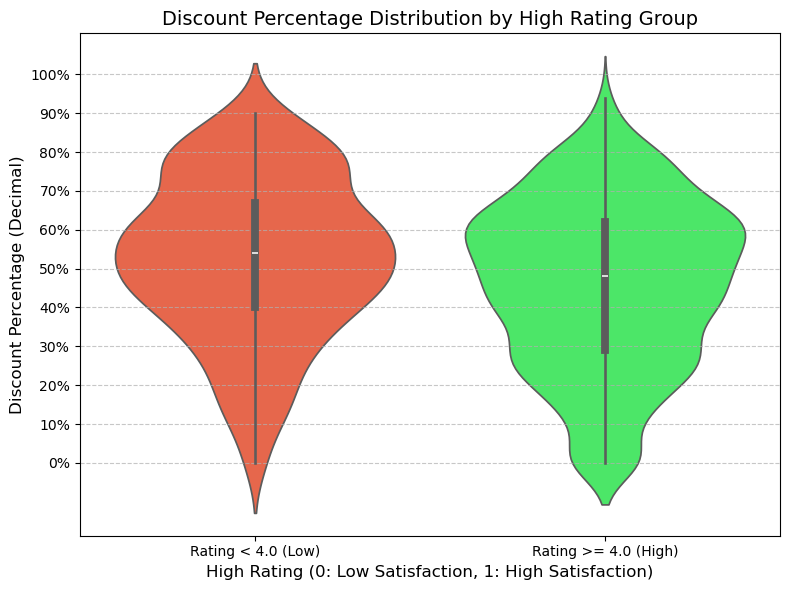

In [45]:
plt.figure(figsize=(8, 6))

# Create a Violin Plot to visualize the distribution of discount percentage
# for High Rating (1) and Low Rating (0) groups.
sns.violinplot(
    x='High_Rating', 
    y='discount_percentage_dec', 
    data=amazon_sales_cleaned, 
    palette=['#FF5733', '#33FF57'] # Custom colors for distinction
)

plt.title('Discount Percentage Distribution by High Rating Group', fontsize=14)
plt.xlabel('High Rating (0: Low Satisfaction, 1: High Satisfaction)', fontsize=12)
plt.ylabel('Discount Percentage (Decimal)', fontsize=12)
plt.xticks([0, 1], ['Rating < 4.0 (Low)', 'Rating >= 4.0 (High)'])
plt.yticks(np.arange(0, 1.1, 0.1), [f'{i*100:.0f}%' for i in np.arange(0, 1.1, 0.1)]) # Format Y-axis as percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Insights from Violin Plot: Discount Percentage by Rating Group

The violin plot compares discount percentage distributions between **low-rated** (Rating < 4.0) and **high-rated** (Rating ≥ 4.0) items.

**Key Takeaways:**
- **Low-rated items** (Rating < 4.0) show a tendency toward **higher discounts**, often clustering around 40–60%, with a noticeable peak at very high discounts (75–85%).  
  - This suggests that deeper discounts may be necessary to drive sales when customer satisfaction is low.  

- **High-rated items** (Rating ≥ 4.0) display a **broader spread** of discount strategies.  
  - Many fall within 20–30% discounts, others cluster around 55–70%, and some succeed with little or no discount.  
  - The median discount is slightly lower compared to low-rated items, indicating **less reliance on extreme discounts**.  

**Business Implication:**  
High customer satisfaction reduces the need for heavy discounting. Low-rated items often require steeper discounts to attract buyers, while high-rated items can maintain sales performance even with modest or no discounts.

--- Mean and Median Rating Count by High Rating Group ---
                 mean  median  count
High_Rating                         
0             9186.93  1988.0    353
1            21210.46  6753.0   1109


C:\Users\rharv\AppData\Local\Temp\ipykernel_17076\1257932702.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


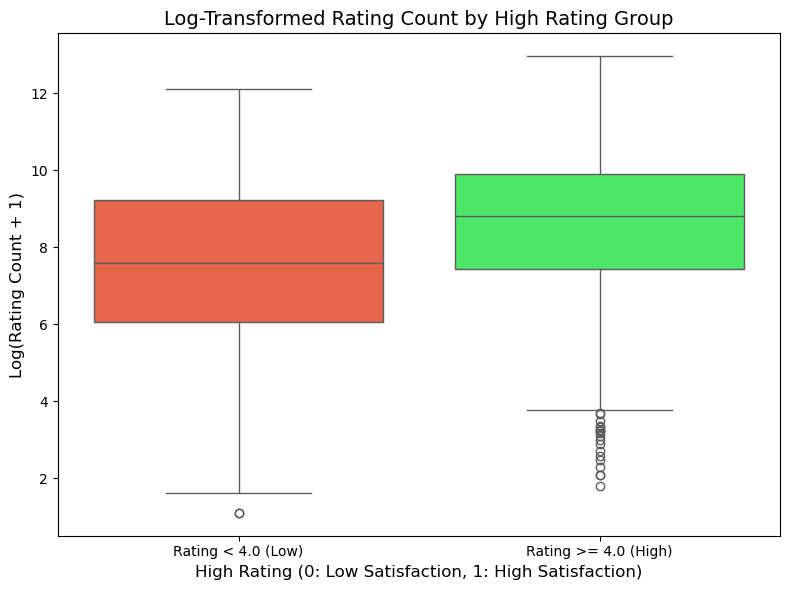

In [47]:
# Create a log-transformed version of the rating count for better visualization
# Add a small value (1) to prevent log(0) errors, though all are > 0 after cleaning
amazon_sales_cleaned['log_rating_count'] = np.log1p(amazon_sales_cleaned['rating_count_clean'])

# 2. Calculate the median and mean of the original rating count for both groups
count_summary = amazon_sales_cleaned.groupby('High_Rating')['rating_count_clean'].agg(['mean', 'median', 'count']).round(2)
print("--- Mean and Median Rating Count by High Rating Group ---")
print(count_summary)

# Visualize the distribution of log-transformed rating count
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='High_Rating',
    y='log_rating_count',
    data=amazon_sales_cleaned,
    palette=['#FF5733', '#33FF57']
)
plt.title('Log-Transformed Rating Count by High Rating Group', fontsize=14)
plt.xlabel('High Rating (0: Low Satisfaction, 1: High Satisfaction)', fontsize=12)
plt.ylabel('Log(Rating Count + 1)', fontsize=12)
plt.xticks([0, 1], ['Rating < 4.0 (Low)', 'Rating >= 4.0 (High)'])
plt.tight_layout()
plt.show()

## EDA Finding 4: Popularity Drives High Ratings

The analysis of **Rating Count** (our proxy for product popularity/sales volume) shows a strong correlation between the quantity of reviews and the likelihood of achieving a High Rating ($\ge 4.0$).

| High Rating Group | Mean Rating Count | Median Rating Count | Total Count |
| :--- | :--- | :--- | :--- |
| **0 (Low Satisfaction)** | 9,187 | 1,988 | 353 |
| **1 (High Satisfaction)** | 21,210 | 6,753 | 1,109 |

---

### Key Insights

1.  **High Ratings are Concentrated in Popular Products:** Products that achieve a High Rating ($\text{Group 1}$) have a **Mean Rating Count that is $\mathbf{2.3\times}$ higher** and a **Median Rating Count that is $\mathbf{3.4\times}$ higher** than products that fall into the Low Rating group ($\text{Group 0}$).
2.  **The Median is More Telling:** The large difference in the **Median** ($\mathbf{6,753}$ vs. $\mathbf{1,988}$) is critical. It suggests that a product has to reach a significant sales and review volume threshold before it typically settles into the High Rating group.
3.  **Low Ratings Stand Out:** Low-rated products, despite often having deep discounts (as found in EDA Finding 3), rarely achieve the same level of popularity as their high-rated counterparts.

### Business Implication

While product quality is necessary, this data suggests that **sales and positive reviews reinforce each other**. Business efforts should focus on driving initial sales velocity for products deemed high quality, as high popularity is a strong feature that predicts a sustained high rating. This feature, $\mathbf{rating\_count\_clean}$, will be a highly influential predictor in the final model.

In [48]:
# Create a log-transformed version of the discounted price
# Add 1 to handle zero/near-zero values, though prices are generally positive.
amazon_sales_cleaned['log_discounted_price_usd'] = np.log1p(amazon_sales_cleaned['discounted_price_usd'])

# Print summary statistics
print("\n--- Summary Statistics for Discounted Price (USD) ---")
print(amazon_sales_cleaned['discounted_price_usd'].describe().round(2))


--- Summary Statistics for Discounted Price (USD) ---
count    1462.00
mean       38.17
std        84.76
min         0.48
25%         3.96
50%         9.74
75%        24.38
max       951.10
Name: discounted_price_usd, dtype: float64


Text(0, 0.5, 'Count')

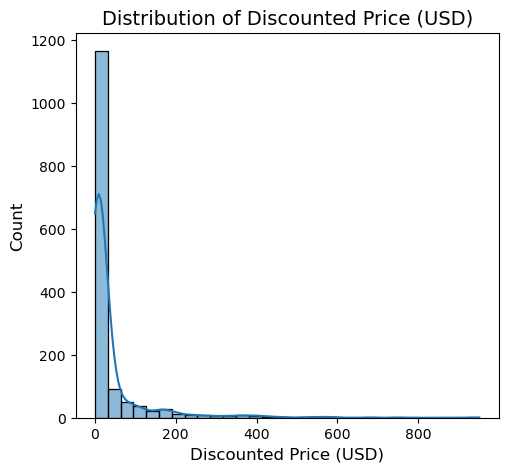

In [49]:
# Plot the original discounted price (to see the raw skew)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # First subplot: Original Price
sns.histplot(amazon_sales_cleaned['discounted_price_usd'], bins=30, kde=True)
plt.title('Distribution of Discounted Price (USD)', fontsize=14)
plt.xlabel('Discounted Price (USD)', fontsize=12)
plt.ylabel('Count', fontsize=12)

Text(0, 0.5, 'Count')

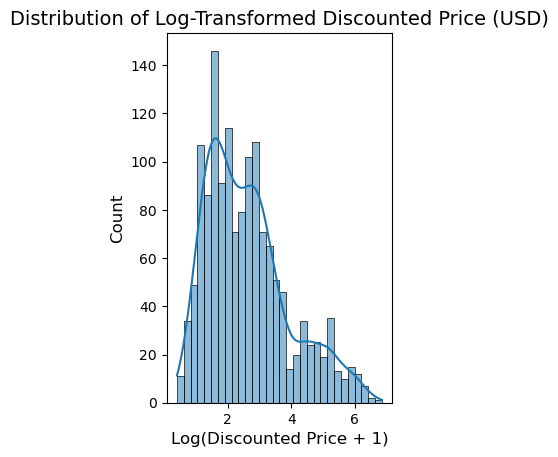

In [50]:
# Plot the log-transformed discounted price (to see the true shape)
plt.subplot(1, 2, 2) # Second subplot: Log-Transformed Price
sns.histplot(amazon_sales_cleaned['log_discounted_price_usd'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Discounted Price (USD)', fontsize=14)
plt.xlabel('Log(Discounted Price + 1)', fontsize=12)
plt.ylabel('Count', fontsize=12)

The analysis of the `discounted_price_usd` reveals a market heavily dominated by **low-cost products**, which is visually apparent by the heavy right-skew confirmed in the histograms.

### Key Insights from Price Statistics

The disparity between the average and the median highlights the nature of the products in this dataset:

| Metric | Value (USD) | Implication |
| :--- | :--- | :--- |
| **Mean Price** | $38.17 | This average is heavily inflated by rare, expensive items (the long tail). |
| **Median Price (50%)** | **$9.74** | **The true center of the market.** Half of all products in the dataset are sold for less than $9.74. |
| **75th Percentile** | $24.38 | Three-quarters of all products in the dataset are sold for less than $24.38. |
| **Maximum Price** | $951.10 | The presence of very high-priced items (potential outliers) necessitates robust feature handling. |

### Conclusion

The primary market for this dataset is in the **low-cost consumer goods** segment.

* The majority of customer reviews are generated by items sold for **less than \$25**.
* The large difference between the Mean (\$38.17) and the Median (\$9.74) confirms the data is heavily **right-skewed**.

To accurately model the effect of price, the **log-transformed price feature** (`log_discounted_price_usd`) must be used in the classification model, as it correctly represents the true distribution of value experienced by the average customer.

--- Mean and Median Review Length by High Rating Group ---
                mean  median  count
High_Rating                        
0            1147.75   682.0    353
1            1473.79   860.0   1109


C:\Users\rharv\AppData\Local\Temp\ipykernel_17076\570744586.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


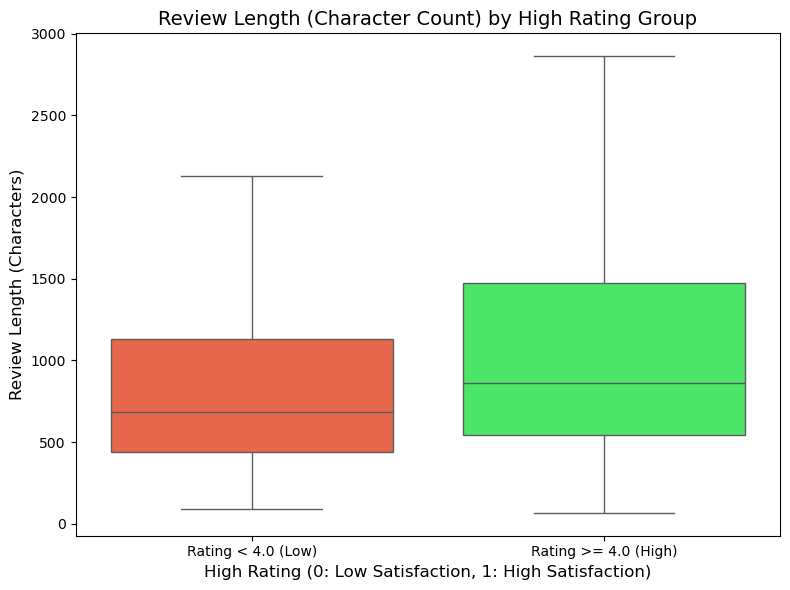

In [51]:
# Create a new feature for the length of the review content
amazon_sales_cleaned['review_length'] = amazon_sales_cleaned['review_content'].astype(str).str.len()

# Calculate the median and mean review length for both groups
length_summary = amazon_sales_cleaned.groupby('High_Rating')['review_length'].agg(['mean', 'median', 'count']).round(2)
print("--- Mean and Median Review Length by High Rating Group ---")
print(length_summary)

# Visualize the distribution of review length (using a Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='High_Rating',
    y='review_length',
    data=amazon_sales_cleaned,
    showfliers=False, # Hide extreme outliers for a cleaner look
    palette=['#FF5733', '#33FF57']
)
plt.title('Review Length (Character Count) by High Rating Group', fontsize=14)
plt.xlabel('High Rating (0: Low Satisfaction, 1: High Satisfaction)', fontsize=12)
plt.ylabel('Review Length (Characters)', fontsize=12)
plt.xticks([0, 1], ['Rating < 4.0 (Low)', 'Rating >= 4.0 (High)'])
plt.tight_layout()
plt.show()